# Modèle Naïve Bayes
## Imports

In [4]:
import findspark
findspark.init()
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Variables de contexte

In [7]:
spark1 = SparkSession.builder\
            .master("local[*]")\
            .appName("NB_Twitter")\
            .getOrCreate()

path = "../resources/training_noemoticon.csv"

schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("query", StringType(), True),
    StructField("author", StringType(), True),
    StructField("tweet", StringType(), True)])

## Chargement du dataset et séparation train/test

In [8]:
df = spark1.read.csv(path,
                     inferSchema=True,
                     header=False,
                     schema=schema)

df.dropna()

(train_set, test_set) = df.randomSplit([0.80, 0.20], seed = 2000)

## HashingTF - IDF (paramètres par défaut)

In [9]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

nb = NaiveBayes(modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, nb])

In [12]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7240768131408636
Precision: 0.724281564156498
Recall: 0.7240768131408637
CPU times: total: 62.5 ms
Wall time: 19 s


## HashingTF - IDF (paramètres customisés)

In [12]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

nb = NaiveBayes(modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, nb])

In [13]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7494854325807199
Precision: 0.7495385657216659
Recall: 0.7494854325807198
CPU times: total: 250 ms
Wall time: 1min


## CountVectorizer - IDF (paramètres par défaut)

In [16]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

nb = NaiveBayes(modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, nb])

In [17]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7578530182741815
Precision: 0.758573843019299
Recall: 0.7578530182741816
CPU times: total: 188 ms
Wall time: 1min 40s


## CountVectorizer - IDF (paramètres customisés)

In [18]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
nb = NaiveBayes(modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, nb])

In [19]:
%%time
pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(test_set)
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.768012987744224
Precision: 0.7683262461795766
Recall: 0.768012987744224
CPU times: total: 328 ms
Wall time: 1min 16s


# CountVectorizer + NGram + ChisQSelector

In [8]:
def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    nb = [NaiveBayes(modelType="multinomial")]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + nb)

In [11]:
%%time
pipelineFit = build_trigrams().fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7867376112810696
Precision: 0.7872522985287924
Recall: 0.7867376112810696
CPU times: total: 406 ms
Wall time: 6min 41s


## Cross-Validation 10-fold

In [13]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

nb = NaiveBayes(modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, nb])

In [14]:
param_grid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()
    
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

In [15]:
%%time
pipelineFit = cv.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

bestModel = pipelineFit.bestModel
pipelineFit.getEstimatorParamMaps()[np.argmax(pipelineFit.avgMetrics)]

Accuracy: 0.7680442684384052
Precision: 0.7683548121878483
Recall: 0.7680442684384052
CPU times: total: 20.8 s
Wall time: 44min 6s


{Param(parent='NaiveBayes_943c051d4d20', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 1.0}

## Stats

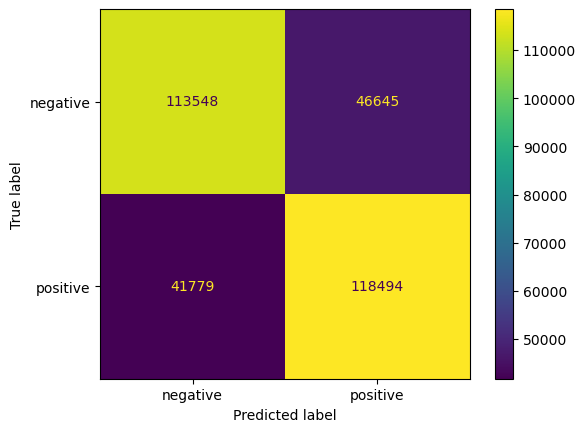

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])